We take a brief sojourn from figuring out how much carbon or serpentintie is around to plot the maps made in the previous notebook. This is important for two reasons:

1) Visualisation is critical to ensure that all calculations have been performed correctly (it isn't foolproof, but it's very obvious straight away if we've missed a decimal or made an error. Infact it was pretty much the first thing I was ever taught in geology: 'if in doubt, draw it'). In particular, before we even plot the data we should have some ideas about what it should look like. For example:
    a) it should be somewhat symmetrical on each side of a ridge segment
    b) it shouldn't overlap continents
    c) if timesteps are viewed sequentially, we should see seafloor 'subduct' at a subduction zone
    d) serpentinite should be thickest where spreading rate is slowest (e.g. SWIR, Atlantic)
    
2) Geology is a spatial science, many relationships and explanations can be identified and established from visual inspection of data

For plotting we use the pretty incredibly cartopy (pronounced cart-o-pie, apparently). I use Viridis for my colourscale because it reminds of the rainbow paddle pops from when I was growing up, but the Scientific Colour Maps by Fabio Crameri (Crameri 2018a, b) also have a bunch of nice colour schemes (I am quite partial to Tokyo and Berlin—there's some code included to use one of those colour maps included below).

References

Crameri, F. (2018a), Scientific colour-maps. Zenodo. http://doi.org/10.5281/zenodo.1243862

Crameri, F. (2018b), Geodynamic diagnostics, scientific visualisation and StagLab 3.0, Geosci. Model Dev., 11, 2541-2562, doi:10.5194/gmd-11-2541-2018

In [23]:
import numpy as np
import pygplates
from netCDF4 import Dataset
import cartopy.crs as ccrs
import ScientificColourMaps5 as SCM5
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [13]:
#load data
raster_dir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/output/rasters/'
datadir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/Sample_Data/'
savedir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/output/'

rotfile = '%sMatthews_etal_GPC_2016_410-0Ma_GK07.rot' % datadir
COBs = '%sGlobal_EarthByte_GeeK07_COB_Terranes_Matthews_etal.gpml' % datadir
coastlines = '%sGlobal_coastlines_2015_v1_low_res_ASM.gpml' % datadir
topologies = ['%sMatthews_etal_GPC_2016_MesozoicCenozoic_PlateTopologies.gpmlz' % datadir,
              '%sMatthews_etal_GPC_2016_Paleozoic_PlateTopologies.gpmlz' % datadir]


rotation_model = pygplates.RotationModel(rotfile)

#some polygons are disguised as polylines, need to force them all to be polygons
COBs = pygplates.FeatureCollection(COBs)
polygons = []
for feature in COBs:
    for geom in feature.get_geometries():
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))
        polygons.append(polygon)

COBs = pygplates.FeatureCollection(polygons)

coastlines = pygplates.FeatureCollection(coastlines)
polygons = []
for feature in coastlines:
    for geom in feature.get_geometries():
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))
        polygons.append(polygon)

coastlines = pygplates.FeatureCollection(polygons)


In [37]:
#if we want to use not viridis we can get some hexxy values from this. First entry is the '0' value
cmap = SCM5.tokyo    # PiYG
for i in range(1): #cmap.N, alternatively
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    print matplotlib.colors.rgb2hex(rgb)

#1a0e34


0
50
100
150
200


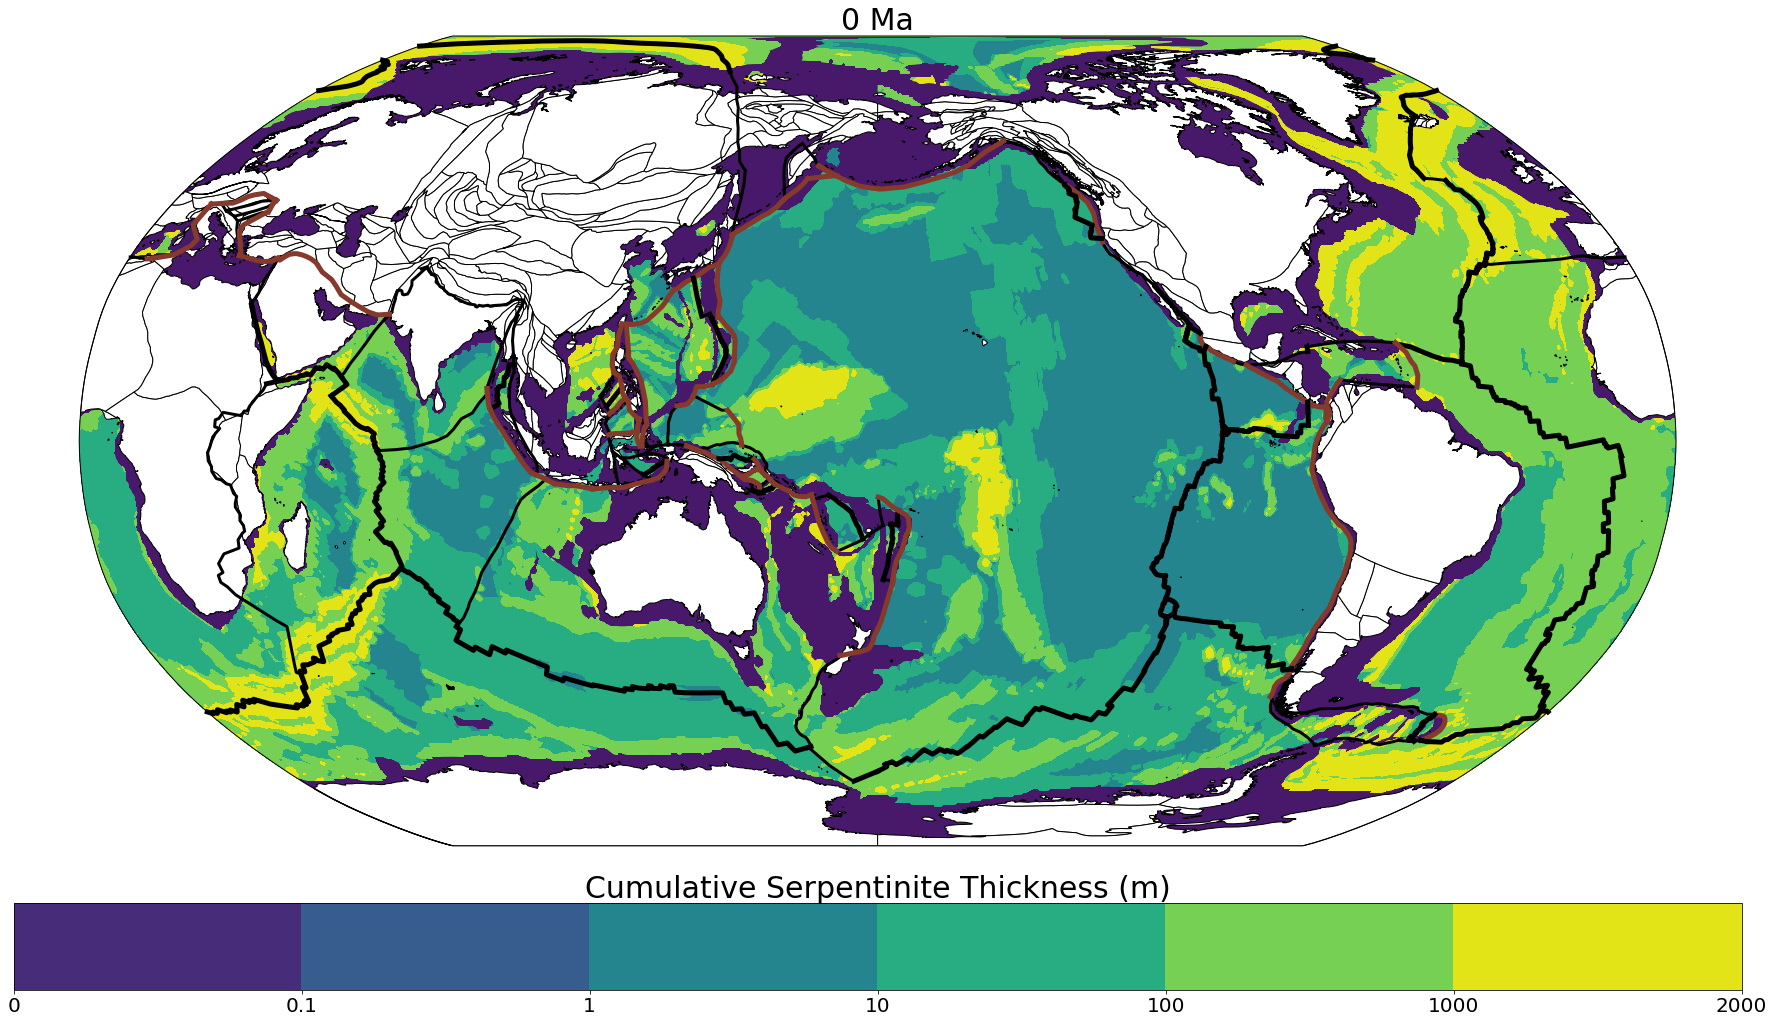

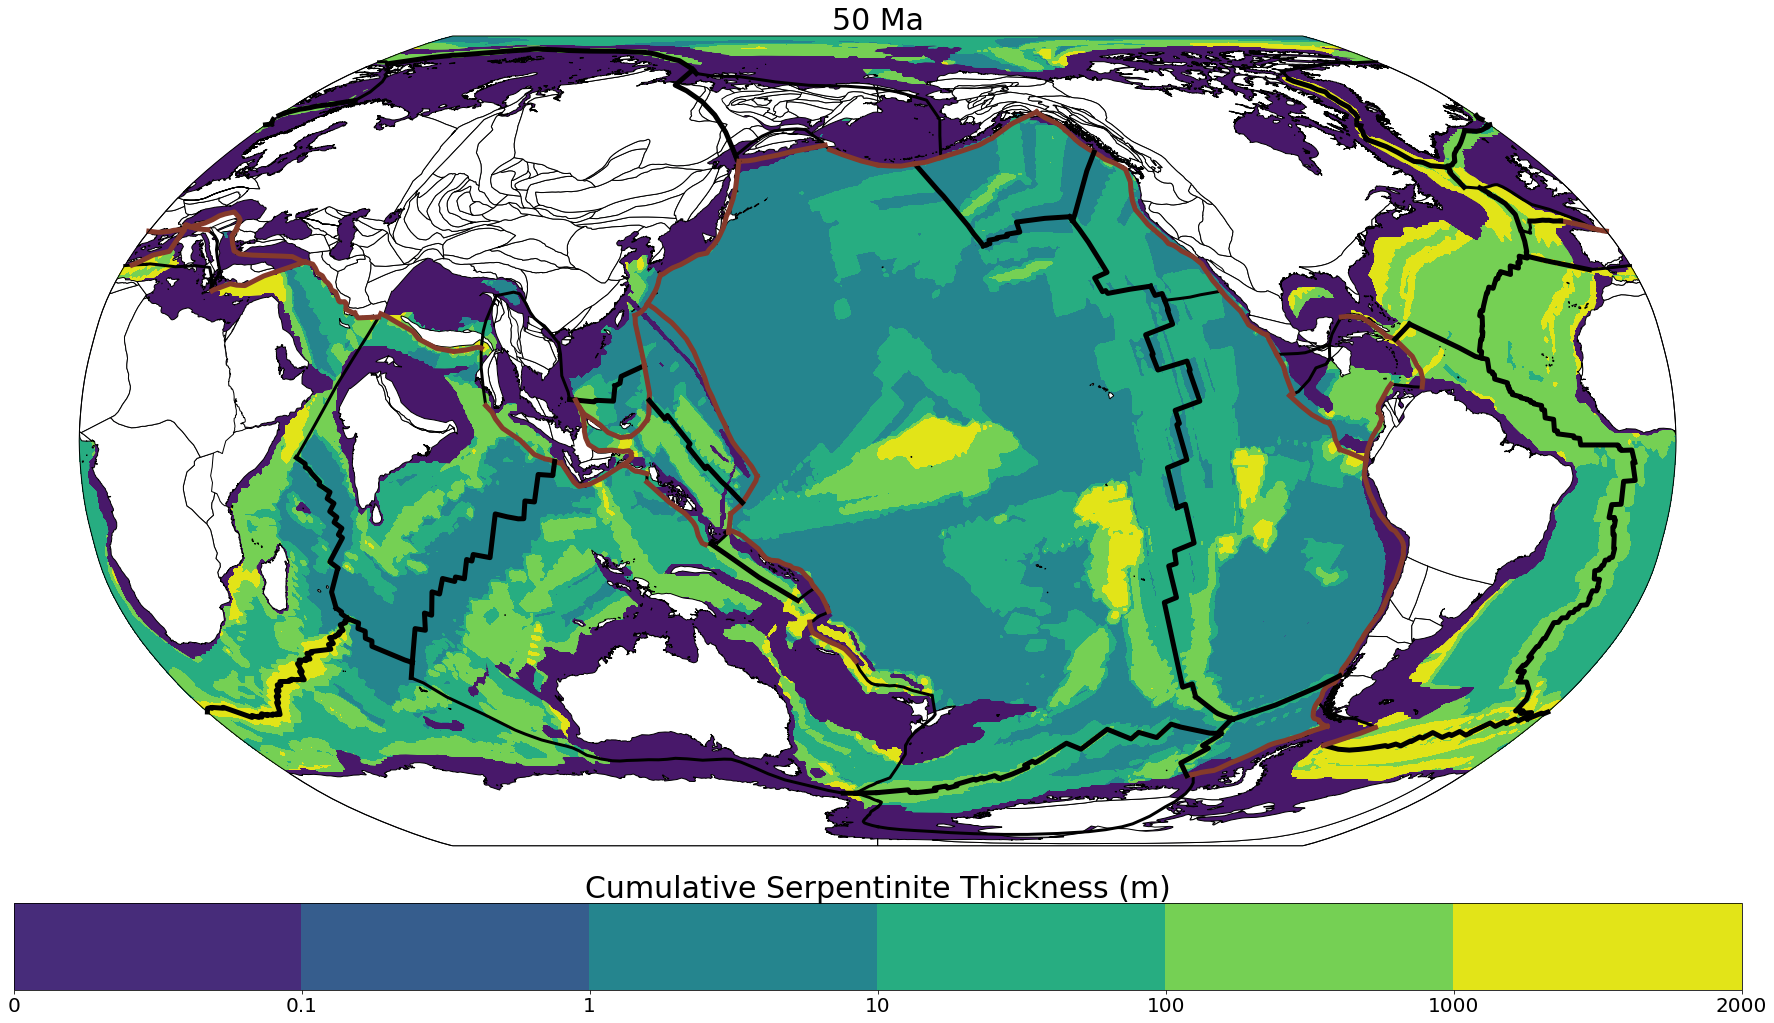

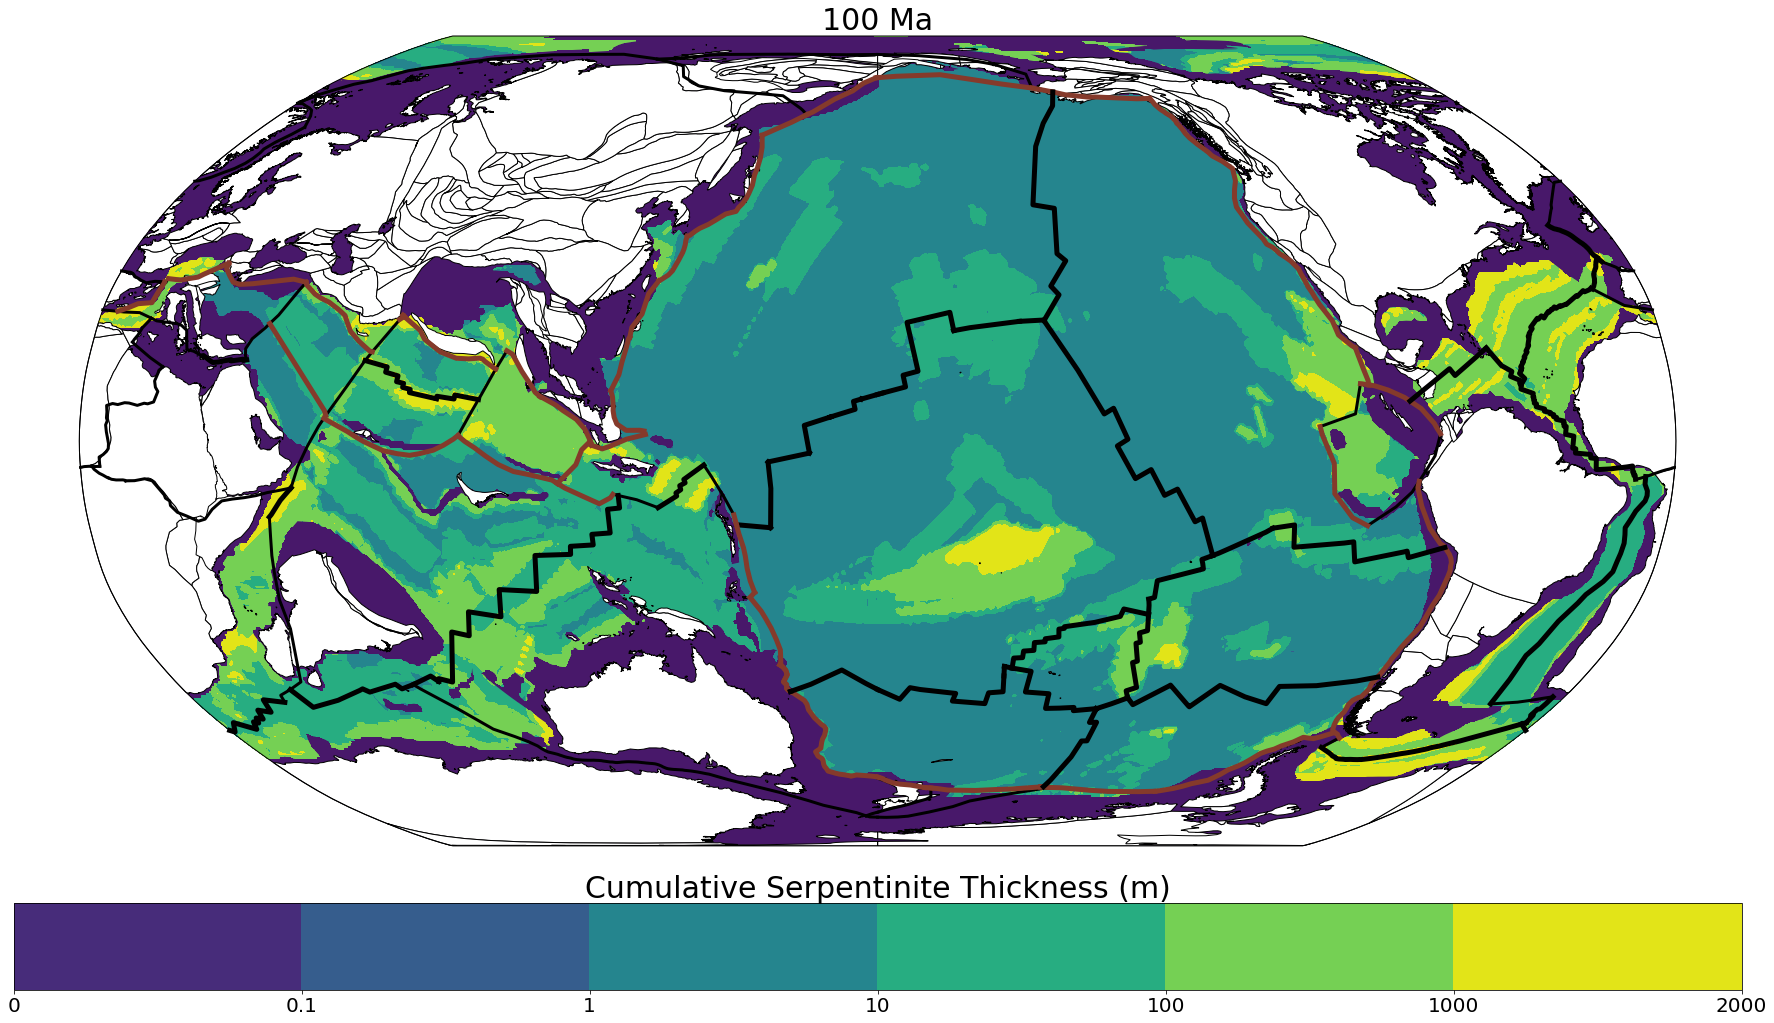

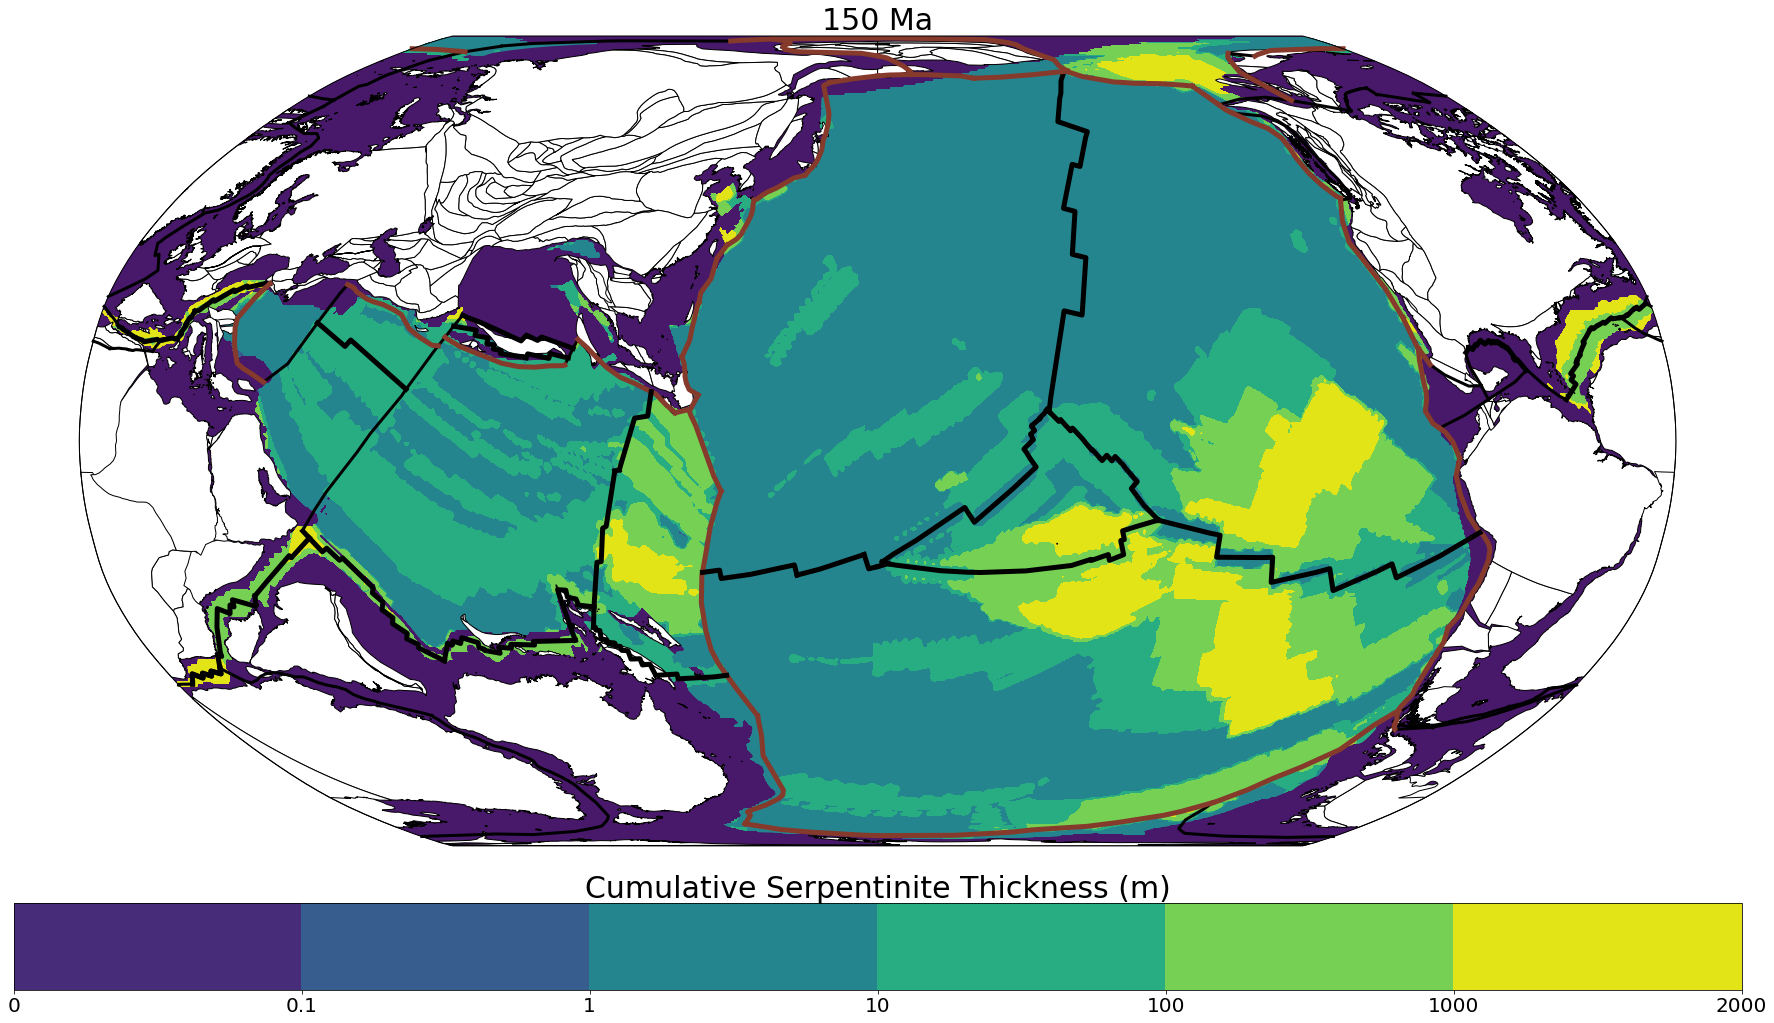

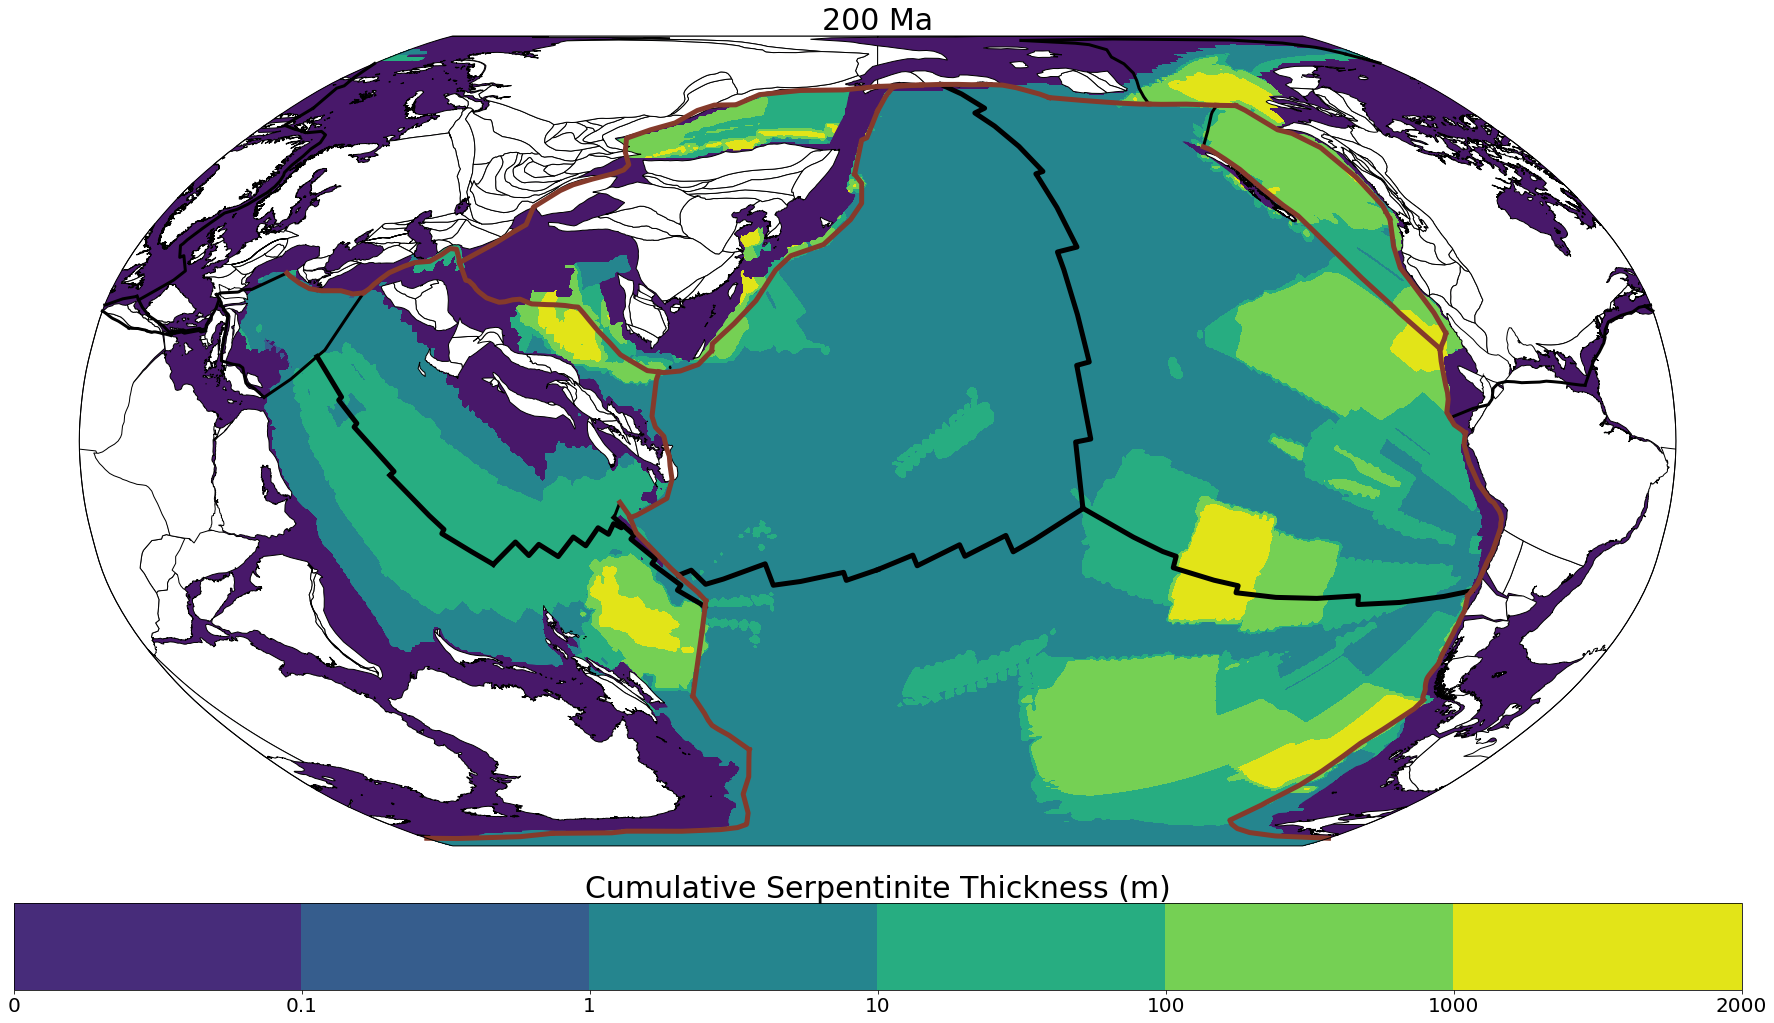

In [40]:
#setup cartopy parameters
data_crs = ccrs.Geodetic()
poly_data_crs = ccrs.PlateCarree()

#usually i use viridis, but the scientific colour maps of Crameri (2018) are nice, if you do use them you might
#have to change the cm.set_bad to be the appropriate colour (atm it is set to the '0' values of viridis)
cm = plt.get_cmap('viridis')#SCM5.tokyo
#this lets us colour nans properly (commented out is for viridis)
back_colour = '#48186a'#'#1a0e34'
cm.set_bad(back_colour)

#define times for plotting
times = np.arange(0,250,50)
for time in times:
    print time
    title = str(time) + ' Ma'
    
    #set up figure
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24,12),subplot_kw={'projection': ccrs.Robinson(180)})
    ax.background_patch.set_facecolor(back_colour)#ergh
    date_line_wrapper = pygplates.DateLineWrapper(0) 
    
    #reconstruct and resolve plate model
    reconstructed_coastlines = []
    reconstructed_COBs = []
    resolved_topologies = []
    shared_boundary_sections = []

    #here we load in our rasters from notebook 6
    #NB in the publication figures were made using Pacific Ocean Spreading Rates (POSR), here I plot with 
    #Plate Model Spreaidng Rates (PMSR)
    
    #carbon = '%sPMSR_C_%s_Ma_NN_COB_masked.grd' % (raster_dir, time)
    serp = '%sPMSR_Serp_%s_Ma_NN_COB_masked.grd' % (raster_dir, time)
    SR = '%sPMSR_SR_%s_Ma_NN_COB_masked.grd' % (raster_dir, time)
    #load datasets using netcdf4
    zval = Dataset('%s' % serp)
    spreading = Dataset('%s' % SR)
    #carbs = Dataset('%s' % carbon)
    #
    #for plotting
    lons = zval.variables['lon'][::]
    lats = zval.variables['lat'][::]
    vals = zval.variables['z'][::]
    val2 = vals
    rate = spreading.variables['z'][::]
    
    #if using POSR then we need to undo our fix from the processing step
    
    #threshold is .1 for C, 10 for serps
    threshold = 10 
    #for ind,i in enumerate(vals):
    #    for ind2, j in enumerate(i):
    #        if j > threshold:
    #            val2[ind][ind2] = j/rate[ind][ind2]*2/1000000
    #for ind,i in enumerate(vals):
    #    for ind2, j in enumerate(i):
    #        if j < 1e-6:
    #          #print j
    #            val2[ind][ind2] = j*rate[ind][ind2]/100
    
    #val2 = np.ma.filled(val2, fill_value=0)
    lons_mesh, lats_mesh = np.meshgrid(lons, lats)
    
    #limits for carbon
    #v_min, v_max = 0,7.2 #carbon
    #levels = np.linspace(v_min, v_max, 9)#carbon
    
    #limits for serps
    levels=[1e-2,1e-1,1e0,1e1,1e2,1e3,1e4]#serp, also add lognorm  
    
    #plot serps
    CS = ax.contourf(lons_mesh, lats_mesh, val2*1000, transform=poly_data_crs, 
                      levels=levels, cmap=cm, norm = LogNorm())
    #plot carbon
    #CS = ax.contourf(lons_mesh, lats_mesh, val2*1000, transform=poly_data_crs, 
     #                 levels=levels, vmin=0, vmax=7, cmap=cm)

    #colourbar axes are pretty much the worse
    #values are left bottom width height
    cbaxes = fig.add_axes([0, -0.15, 1, 0.1]) 
    cbar = fig.colorbar(CS, orientation='horizontal', shrink=0.6,ax=ax, cax=cbaxes)
    cbar.ax.tick_params(labelsize=20) 
    cbar.ax.set_title('Cumulative Serpentinite Thickness (m)', fontsize=30)
    cbar.set_ticklabels([0,0.1,1,10,100,1000,2000])
    
    #plot other stuff on top so it makes more sense
    
    #Continent ocean boundaries
    pygplates.reconstruct(COBs,rotation_model,reconstructed_COBs,time)
    for coastline in reconstructed_COBs:
        coastline_geom = pygplates.PolygonOnSphere(coastline.get_reconstructed_geometry())
        wrapped_coastlines = date_line_wrapper.wrap(coastline_geom, 1)
        for wrapped_coastline in wrapped_coastlines:
            wrapped_coastlines_lat = []
            wrapped_coastlines_lon = []
            for wrapped_coastline_point in wrapped_coastline.get_exterior_points():
                wrapped_coastline_lat_lon = wrapped_coastline_point.get_latitude(), wrapped_coastline_point.get_longitude()
                wrapped_coastlines_lat.append(wrapped_coastline_point.get_latitude())
                wrapped_coastlines_lon.append(wrapped_coastline_point.get_longitude())
            #ax.plot(wrapped_coastlines_lon, wrapped_coastlines_lat, color='k', lw=0.1, transform=data_crs)
            ax.fill(wrapped_coastlines_lon, wrapped_coastlines_lat, back_colour, fill=True, lw=1, transform=poly_data_crs)

    #present day coastlines
    pygplates.reconstruct(coastlines,rotation_model,reconstructed_coastlines,time)
    for coastline in reconstructed_coastlines:
        coastline_geom = pygplates.PolygonOnSphere(coastline.get_reconstructed_geometry())
        wrapped_coastlines = date_line_wrapper.wrap(coastline_geom, 1)
        for wrapped_coastline in wrapped_coastlines:
            wrapped_coastlines_lat = []
            wrapped_coastlines_lon = []
            for wrapped_coastline_point in wrapped_coastline.get_exterior_points():
                wrapped_coastline_lat_lon = wrapped_coastline_point.get_latitude(), wrapped_coastline_point.get_longitude()
                wrapped_coastlines_lat.append(wrapped_coastline_point.get_latitude())
                wrapped_coastlines_lon.append(wrapped_coastline_point.get_longitude())
            #ax.plot(wrapped_coastlines_lon, wrapped_coastlines_lat, color='k', lw=0.1, transform=data_crs)
            ax.fill(wrapped_coastlines_lon, wrapped_coastlines_lat, 'white', edgecolor='k', fill=True, lw=1, transform=poly_data_crs)
    
    
    #plate boundaries
    pygplates.resolve_topologies(topologies, rotation_model, resolved_topologies, time, shared_boundary_sections)
    for shared_boundary_section in shared_boundary_sections:
        
        #subduction zones
        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                # plot subduction zones
                #if shared_sub_segment.get_feature().get_geometry() !=None:
                tmp = shared_sub_segment.get_resolved_geometry()

                wrapped_polylines = date_line_wrapper.wrap(tmp)
                for wrapped_polyline in wrapped_polylines:
                    mor_wrapped_point_lat = []
                    mor_wrapped_point_lon = []
                    for wrapped_point in wrapped_polyline.get_points():
                        mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                        mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                    ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#853a2b',
                            linewidth=5, alpha=1, zorder=2, transform=data_crs)

        #mid ocean ridges
        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_mid_ocean_ridge:
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                tmp = shared_sub_segment.get_resolved_geometry()

                wrapped_polylines = date_line_wrapper.wrap(tmp)
                for wrapped_polyline in wrapped_polylines:
                    mor_wrapped_point_lat = []
                    mor_wrapped_point_lon = []
                    for wrapped_point in wrapped_polyline.get_points():
                        mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                        mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                    ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='k',
                            linewidth=5, alpha=1, zorder=2, transform=data_crs)


        #transforms (or other boundaries if mis-labelled)
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            # plot subduction zones
            #if shared_sub_segment.get_feature().get_geometry() !=None:
            tmp = shared_sub_segment.get_resolved_geometry()

            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                trans_wrapped_point_lat = []
                trans_wrapped_point_lon = []
                for wrapped_point in wrapped_polyline.get_points():
                    trans_wrapped_point_lat.append(wrapped_point.get_latitude())
                    trans_wrapped_point_lon.append(wrapped_point.get_longitude())
                ax.plot(trans_wrapped_point_lon,trans_wrapped_point_lat, color='k',
                        linewidth=3, alpha=1, zorder=1, transform=data_crs)

    #set title of plot
    ax.set_title(title, fontsize=30)
    fig.tight_layout()
    
    #save figu
    #plt.savefig('%s%s_carbs.png' % (savedir, time), rasterized=True) 
    #fig.savefig('%s%s_serps.pdf' % (savedir, time),bbox_inches='tight', rasterized=True)
    
    #if making many figures (100+) then you might have to close them after they're made so your computer doesn't
    #crash
    #plt.close(fig)
